# Cryosphere model Comparison tool (CmCt) Dynamic Thickness Tool

In [1]:
import numpy as np
import h5py
import os
import xarray as xr
import pyproj
import cartopy.crs as ccrs
import time
from datetime import datetime
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.io.shapereader as shpreader

## About This Tool

The CmCt Dynamic Thickness Tool compares the user's uploaded ice sheet model to dynamic thickness data from IMAU, GSFC, or GEMB observation data. This observation data is a rectangular grid in UTM zone 24N coordinates but the model is expected as a rectangular grid in ISMIP6 polar-stereographic coordinates (see the Input Data Requirements Section). The model is bilinearly interpolated to observation space and the residual is outputted as a netCDF4 file in observation space. 

The model currently uses these three datasets made by CREDIT HERE, and available upon request from ACCESS HERE. These datasets include dynamic thickness anomaly data from balance years 1995 to 2021: `Dynamic_h_Greenland_GEMB_1994_2021.nc`, `Dynamic_h_Greenland_GSFC_1994_2021.nc`, and `Dynamic_h_Greenland_IMAU_1994_2020.nc`. See OBSERVATION DATA DOCUMENTATION HERE for more information about these datasets.

## Input Data Requirements

### Input netCDF file requirements
The model file must contain these four variables: x, y, time, and dh. 

#### Coordinate System (x and y variables)
Coordinates are defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/ISMIP6-Projections-Greenland). This means that in the model netCDF4 file, there must be variables x and y such that x has dimensions (x,) and length A and y has dimensions (y,) and length B

#### Time
Must be an array of integers, floats, or strings representing the number of years since AD 0. "1996", 1996.0, and 1996 are all acceptable entries, but no month, day, time-of-day, or timezone information should be provided. 

#### Dh variable
The CmCt Grace Mascon tool expects the uploaded model to contain dynamic thickness data (the `dh` variable) for the comparison (should be in units of meters). dh must have dimensions (time, y, x) such that dh\[i,j,k] is the change in dynamic thickness anomaly in meters from Sep 1st, time\[i] to Aug 31st, time\[i] + 1 at the position described by (x\[k], y\[j]) in ISMIP6 polar-stereographic space.


### Other Inputs
See the Inputs section for more inputs such as filenames and plotting preferences. One input that bears note is the `year` variable. This is the desired balance year for the comparison. If `year` = 1996, then the observation change in dynamic thickness anomaly from Sep 1st, 1996 to Aug 31st 1997 will be compared with the modelled change in dynamic thickness anomaly from Sep 1st, 1996 to Aug 31st 1997. `year` cannot occur before the start of observation data collection (1995) or before the start of modelled data collection (time\[0]). Likewise, `year` cannot occur after the end of observation data collection (2021 for GSFC and GEMB, 2020 for IMAU) or after the end of modelled data collection (time\[-1]). 

## Inputs

In [2]:
# Observation data
obs_dir = "observation_data/"
obs_fn = "Dynamic_h_Greenland_IMAU_1994_2020.nc"
obs_path = obs_dir + obs_fn

# Model data
model_dir = "model_files/"
model_fn = "partial_model_file.nc"
model_path = model_dir + model_fn

# Desired balance year for comparison (see Input Data Requirements section above)
year = "2008"   # YYYY

# Output filename in which to store residuals
save_nc = False
output_dir = "output_files/"
output_fn = "temp_res"
output_fn = output_dir + output_fn + ".nc"

# Plotting preferences
plot = True
save_plot = True   # Only relevant if plot = True
plot_fn = "output_files/plot.png"

## Read in Observation Data

In [3]:
def read_obs_file(obs_path, year):
    global x_UTM
    global y_UTM
    global crs_wkt
    
    with h5py.File(obs_path, mode='r') as f:
        x_UTM = f['x'][:]
        y_UTM = f['y'][:]

        # If time[i] is equal to '1995', dh[i,:,:] represents the balance year from Sep 1st 1994 to Sep 1st 1995
        time_obs = (f['time'][:]).astype("str")
        
        dh = f['dh'][:]    # Has shape (len(time_obs), len(y_UTM), len(x_UTM))
        
        spatial_ref = f['spatial_ref']
        crs_wkt = spatial_ref.attrs['crs_wkt'].decode('UTF-8')   # Contains coordinate system data

    # Check desired comparison year is not outside of bounds of observation data
    year_dt = datetime.strptime(year, "%Y")
    if datetime.strptime(time_obs[0], "%Y") > year_dt:
        print(f"Error: Desired comparison year ({year}) occurs before first date of observation data ({time_obs[0]})")
        return None
        
    if datetime.strptime(time_obs[-1], "%Y") < year_dt:
        print(f"Error: Desired comparison year ({year}) occurs after last date of observation data ({time_obs[-1]})")
        return None

    # Find the dh in the year specified
    time_idx = np.argwhere(time_obs == year)[0,0]
    dh_obs = dh[time_idx, :, :]
    return dh_obs

## Read in Model Data

In [4]:
def read_model_file(model_path, year):
    global x_mod
    global y_mod

    with h5py.File(model_path, mode='r') as f:
        # See "Input Data Requirements" section for more details on the format of these variables
        x_mod = f['x'][:]
        y_mod = f['y'][:]

        time_mod = f['time'][:]
        time_mod = np.array([str(int(t)) for t in time_mod])
        
        dh = f['dh'][:]

    # Check desired comparison year is not outside of bounds of model data
    year_dt = datetime.strptime(year, "%Y")
    if datetime.strptime(time_mod[0], "%Y") > year_dt:
        print(f"Error: Desired comparison year ({year}) occurs before first date of model data ({time_mod[0]})")
        return None
        
    if datetime.strptime(time_mod[-1], "%Y") < year_dt:
        print(f"Error: Desired comparison year ({year}) occurs after last date of model data ({time_mod[-1]})")
        return None

    # Find the dh in the year specified
    time_idx = np.argwhere(time_mod == year)[0,0]
    dh_mod = dh[time_idx, :, :]
    return dh_mod

## Transform Observation Coordinates from UTM-24N to ISMIP6 polar-stereographic coordinates

In [5]:
def transform_obs_coords(crs_wkt, x_UTM, y_UTM):
    # See "About This Tool" section for observation coordinate system information
    
    # Make a transformer from observation coordinates to model coordinates
    crs_utm = pyproj.crs.CRS.from_wkt(crs_wkt)    # Coordinate system of observation data
    crs_ps = pyproj.crs.CRS(ccrs.Stereographic(central_latitude= 90.0, central_longitude= -45.0, false_easting= 0.0, 
                            false_northing= 0.0, true_scale_latitude= 70.0, globe=ccrs.Globe('WGS84')))    # ISMIP6 coord sys
    utm_to_ps = pyproj.Transformer.from_crs(crs_from = crs_utm, crs_to = crs_ps)

    # Format observation coordinate data into two 1D arrays of the same length
    xv, yv = np.meshgrid(x_UTM, y_UTM)
    x_UTM_points, y_UTM_points = xv.transpose().flatten(), yv.transpose().flatten()

    # Transform observation coordinate points to points in polar-stereographic space
    x_obs, y_obs = utm_to_ps.transform(x_UTM_points, y_UTM_points)
    return x_obs, y_obs

## Interpolate Model Data to Observation Points

In [6]:
def bilinear_interp(x, y, arr, x_query, y_query):
    """
    Bilinearly interpolates the value of arr, defined on a rectangular grid by x and y, at the set of points defined 
    by x_query and y_query. x, y, x_query, and y_query must all be in the same coordinate system.

    Parameters:
    arr: An array of floats of shape (ny, nx)
    x, y: x has shape (nx,) and y has shape (ny,). The entry arr[i][j] corresponds to the point in space defined by 
    y[i] and x[j]. The entries of x and y must be evenly spaced
    x_query, y_query: Both must have shape (n,), where n is the number of query points. It is assumed that x, y, 
    x_query, and y_query are defined in the same coordinate system and that x and x_query represent the same dimension, 
    while y and y_query represent the other dimension 

    Returns: 
    arr_query: An array of floats of shape (n,). arr_query[i] represents the estimated value of arr at the position 
    defined by x_query[i] and y_query[i], estimated using bilinear interpolation. If any query point i is outside the 
    bounds defined by x and y, arr_query[i] will be NaN
    """

    # Query points
    x_query = np.asarray(x_query)
    y_query = np.asarray(y_query)

    # Find the spacing of the x and y arrays
    sx, sy = x[1] - x[0], y[1] - y[0]
    a = sx * sy  # area of each grid cell

    # Find the indices of the four closest points in arr to each query point
    x0 = np.floor((x_query - x[0]) / sx).astype(int)   # Left
    x1 = x0 + 1                                        # Right
    y0 = np.floor((y_query - y[0]) / sy).astype(int)   # Bottom
    y1 = y0 + 1                                        # Top

    # ma[i] is True if both x_query[i] and y_query[i] are within the bounds of the grid defined by x and y
    ma = (x0 >= 0) & (x1 < len(x)) & (y0 >= 0) & (y1 < len(y))

    # Values at each of the reference coordinates
    Ia, Ib, Ic, Id = (np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64),
                     np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64))  # Allocate memory
    Ia[~ma], Ib[~ma], Ic[~ma], Id[~ma] = np.nan, np.nan, np.nan, np.nan    # Set to NaN where x or y are out of bounds
    Ia[ma] = arr[ y0[ma], x0[ma] ]    # Bottom left
    Ib[ma] = arr[ y1[ma], x0[ma] ]    # Top left
    Ic[ma] = arr[ y0[ma], x1[ma] ]    # Bottom right
    Id[ma] = arr[ y1[ma], x1[ma] ]    # Top right

    # Weights for each reference coordinate
    wa, wb, wc, wd = (np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64),
                     np.empty_like(x_query, dtype=np.float64), np.empty_like(x_query, dtype=np.float64))  # Allocate memory
    wa[~ma], wb[~ma], wc[~ma], wd[~ma] = np.nan, np.nan, np.nan, np.nan    # Set to NaN where x or y are out of bounds
    wa[ma] = ((x[x1[ma]] - x_query[ma]) * (y[y1[ma]] - y_query[ma])) / a
    wb[ma] = ((x[x1[ma]] - x_query[ma]) * (y_query[ma] - y[y0[ma]])) / a
    wc[ma] = ((x_query[ma] - x[x0[ma]]) * (y[y1[ma]] - y_query[ma])) / a
    wd[ma] = ((x_query[ma] - x[x0[ma]]) * (y_query[ma] - y[y0[ma]])) / a

    return wa*Ia + wb*Ib + wc*Ic + wd*Id     # arr_query in documentation

# Interpolate and Subtract

In [7]:
def interpolate_model_to_observation_space(x_obs, y_obs, dh_obs, dh_mod):
    # Only query points in the model which are not NaN for the observation (avoids unnecessary interpolation)
    I_ = (~np.isnan(dh_obs)).transpose().flatten()   # I_[i] is False if x_obs[i], y_obs[i] correspond to a point where dh_obs is NaN, True otherwise

    # Bilinearly interpolate model to observation space
    model_dh_interped_flat = bilinear_interp(x_mod, y_mod, dh_mod, x_obs[I_], y_obs[I_])

    # Reshape model array to the same shape as the observation array
    dh_mod_interped = np.empty_like(I_, dtype = np.float64)
    dh_mod_interped[~I_] = np.nan     # Fill with NaN at indices where dh_obs is NaN
    dh_mod_interped[I_] = model_dh_interped_flat
    dh_mod_interped = np.reshape(dh_mod_interped, dh_obs.shape, order = "F")

    return dh_mod_interped

## Plot Observation, Model, and Residual

In [8]:
def plot_obs_mod_res(extent, dh_obs, dh_mod_interped, dh_res, save_plot):
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['figure.dpi'] = 100
    fig = plt.figure(figsize=(24,14))

    """
    crs = ccrs.UTM('24')
    coords = {"x": x_UTM, "y": y_UTM}
    dims = ["y", "x"]
    
    # Observed
    ax1 = plt.subplot(projection = crs)
    #ax1 = plt.subplot(131)
    #ax1.set_extent(extent) # Map bounds, [west, east, south, north]
    xr_obs = xr.DataArray(dh_obs, coords = coords, dims = dims)
    xr.plot.imshow(xr_obs, ax=ax1, transform = crs) 
    ax1.set_title("dh_obs")
    """
    mins = [np.min(dh_obs), np.min(dh_mod_interped), np.min(dh_res)]
    min = np.min(mins)
    maxs = [np.max(dh_obs), np.max(dh_mod_interped), np.max(dh_res)]
    max = np.max(maxs)
    

    ax1 = plt.subplot(131)
    im1 = ax1.imshow(dh_obs, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax1.set_xbound(lower = extent[0], upper = extent[1])
    ax1.set_ybound(lower = extent[2], upper = extent[3])
    ax1.set_xlim(left = extent[0], right = extent[1])
    ax1.set_ylim(bottom = extent[2], top = extent[3])
    ax1.set_title(f"Observed Dynamic Thickness for {year}", fontsize = 18)
    
    
    # Model
    ax2 = plt.subplot(132)
    im2 = ax2.imshow(dh_mod_interped, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax2.set_xbound(lower = extent[0], upper = extent[1])
    ax2.set_ybound(lower = extent[2], upper = extent[3])
    ax2.set_xlim(left = extent[0], right = extent[1])
    ax2.set_ylim(bottom = extent[2], top = extent[3])
    ax2.set_title(f"Modelled Dynamic Thickness for {year} (interpolated)", fontsize = 18)
    

    # Residual
    ax3 = plt.subplot(133)
    im3 = ax3.imshow(dh_res, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax3.set_xbound(lower = extent[0], upper = extent[1])
    ax3.set_ybound(lower = extent[2], upper = extent[3])
    ax3.set_xlim(left = extent[0], right = extent[1])
    ax3.set_ylim(bottom = extent[2], top = extent[3])
    ax3.set_title(f"Residual Dynamic Thickness for {year}", fontsize = 18)
    
    
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    fig.colorbar(im2, cax=cbar_ax)
    fig.colorbar(im3, cax=cbar_ax)
    cbar_ax.set_ylabel("meters", fontsize = 16)

    fig.suptitle("Dynamic Thickness Anomaly Change", fontsize = 24)
    
    if save_plot:
        plt.savefig(plot_fn)
    plt.show()

## Save to netCDF File


In [9]:
def save_residual_to_netcdf(output_fn, dh_res, x_UTM, y_UTM, year, crs_wkt):
    rootgrp = netCDF4.Dataset(output_fn, "w", format="NETCDF4")

    # Record coordinate system
    spatial_ref_var = rootgrp.createVariable("spatial_ref", "i8")
    spatial_ref_var[:] = 0
    spatial_ref_var.crs_wkt = crs_wkt

    # Set up x and y variables
    x_dim = rootgrp.createDimension("x", len(x_UTM))
    y_dim = rootgrp.createDimension("y", len(y_UTM))
    x_var = rootgrp.createVariable("x", "f4", ("x",))
    y_var = rootgrp.createVariable("y", "f4", ("y",))
    x_var[:], y_var[:] = x_UTM, y_UTM
    x_var.units, y_var.units = "meter", "meter"

    # Set up dynamic thickness residual variable
    dh_res_var = rootgrp.createVariable("dh_res", "f4", ("y","x",))
    dh_res_var[:,:] = dh_res
    dh_res_var.coordinates = "spatial_ref"
    dh_res_var.grid_mapping = "spatial_ref"
    dh_res_var.long_name = "Residual of annual dynamic mass/ice thickness (assume ice density of 917 kg/m3) change between Sep 1 of " + year + " and " + str(int(year) + 1)
    dh_res_var.units = "meters"
    rootgrp.close()

## Compute Comparison

In [10]:
def runProcessing(output_fn = output_fn):
    """
    Pipeline:
    1) Read in observation data and select the 2D array of dynamic thickness data for the 
       desired year of comparison (dh_obs). The spatial information is stored in x_UTM and
       y_UTM. x_UTM has length dh_obs.shape[1] and y_UTM has length dh_obs.shape[0]
    2) Read in model data and select the 2D array of dynamic thickness data for the 
       desired year of comparison (dh_mod)
    3) Reshape coordinate information encoded in x_UTM and y_UTM to a set of points 
       described by two 1D arrays (both with length dh_obs.size), which are then converted
       into polar stereographic coordinates. These arrays are x_obs and y_obs.
    4) Bilinearly interpolate from the model's grid in polar stereographic, using x_obs
       and y_obs as the query points. This will return an estimated value of the modelled 
       value at each of the points for which the observation value is known. In other words, 
       the model has been brought to observation space
    5) Compute the residual (model - observation) in observation space
    6) (Optional) Write the residual to a netCDF4 file
    7) (Optional) Plot the observation, model, and residual and optionally save the plot
    """
    
    update_progress(0.0, "Starting...              ", 0.0)
    t = time.time()
    dh_obs = read_obs_file(obs_path, year)     # Sets global variables x_UTM, y_UTM, crs_wkt
    if dh_obs is None:
        return None
    update_progress(0.2, "Read Observation Data    ", time.time() - t)

    
    t = time.time()
    dh_mod = read_model_file(model_path, year)     # Sets global variables x_mod, y_mod
    if dh_mod is None:
        return None
    update_progress(0.4, "Read Model Data          ", time.time() - t)

    
    t = time.time()
    x_obs, y_obs,  = transform_obs_coords(crs_wkt, x_UTM, y_UTM)
    update_progress(0.6, "Transformed Coordinates  ", time.time() - t)

    
    t = time.time()
    dh_mod_interped = interpolate_model_to_observation_space(x_obs, y_obs, dh_obs, dh_mod)
    dh_res = dh_mod_interped - dh_obs
    update_progress(0.8, "Computed Residuals       ", time.time() - t)

    t = time.time()
    save_residual_to_netcdf(output_fn, dh_res, x_UTM, y_UTM, year, crs_wkt)
    update_progress(0.9, "Saved residuals to NetCDF", time.time() - t)
    

    if plot:
        print("Plotting....")
        t = time.time()
        plot_obs_mod_res((x_UTM[0], x_UTM[-1], y_UTM[0], y_UTM[-1]), dh_obs, dh_mod_interped, dh_res, save_plot)
        update_progress(1.0, "Plotted Results          ", time.time() - t)
    
    
    print("Success")
    return "Success"

In [11]:
# update processing progress bar
def update_progress(progress, title, time_elapsed_print):
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100) + f" ({time_elapsed_print} seconds)"
    print(text)   

Starting...               [--------------------] 0.0% (0.0 seconds)
Read Observation Data     [####----------------] 20.0% (2.225205183029175 seconds)
Read Model Data           [########------------] 40.0% (0.5155317783355713 seconds)
Transformed Coordinates   [############--------] 60.0% (1.2267661094665527 seconds)
Computed Residuals        [################----] 80.0% (0.5541772842407227 seconds)
Saved residuals to NetCDF [##################--] 90.0% (0.2188103199005127 seconds)
Plotting....


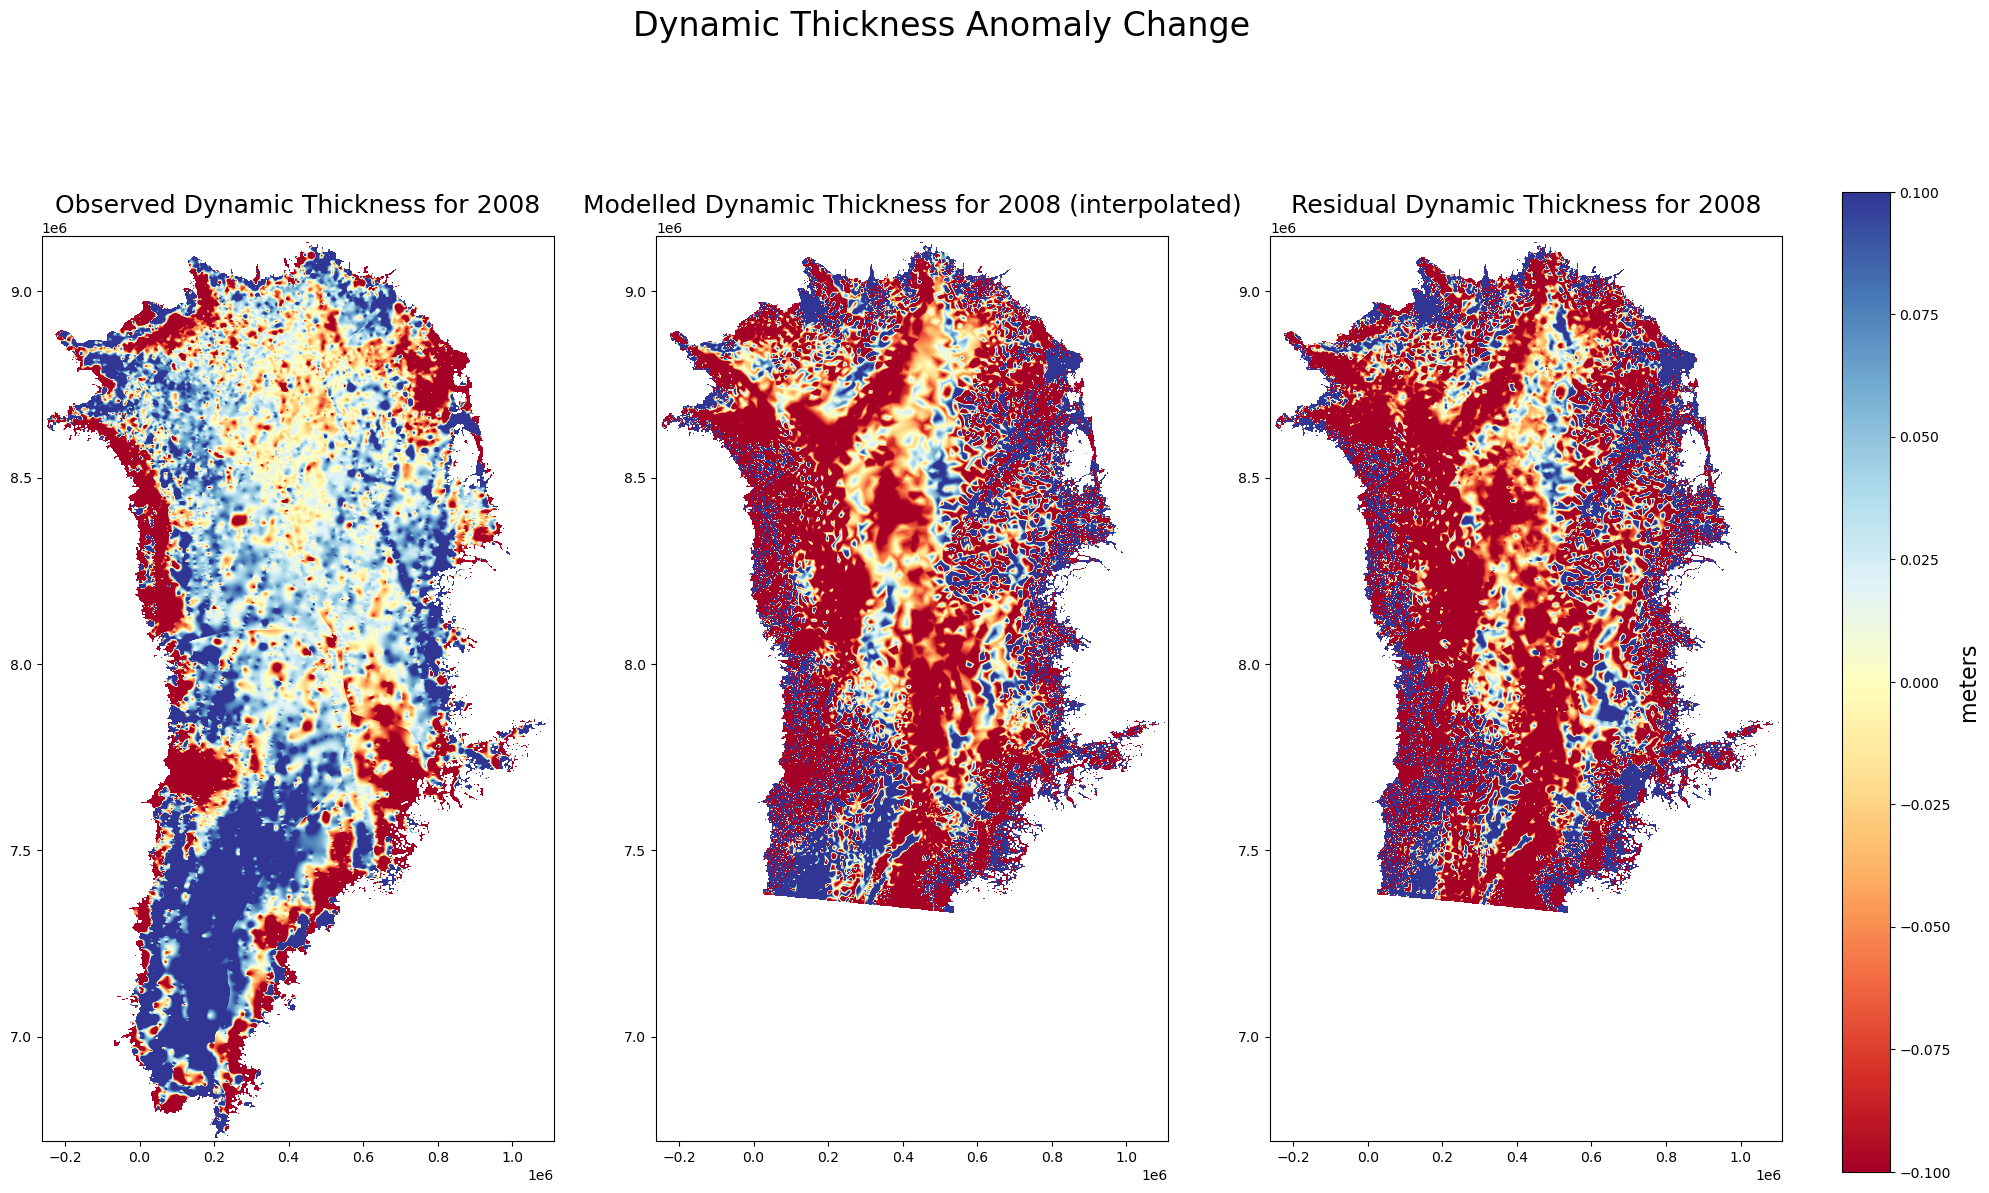

Plotted Results           [####################] 100.0% (3.0687100887298584 seconds)
Success
Total time: 7.846799373626709 seconds


In [12]:
t_tot = time.time()
runProcessing(output_fn)
print("Total time: " + str(time.time() - t_tot) + " seconds")